# Covid19 cases in US states

Here I'll copy some of what was done by Kevin Systrom in [this notebook](http://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).  Specifically, we'll download state infection data from [covidtracking.com](http://covidtracking.com).

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [3]:
# The commands below extract just the cummulative number of positive cases

url = 'https://covidtracking.com/api/v1/states/daily.csv'   

states = pd.read_csv(url,
                     usecols=['date', 'state', 'positive'], # grab only these columns from CSV
                     parse_dates=['date'],                  # .. confusing 
                     index_col=['state', 'date'],           # use these as column labels
                     squeeze=True).sort_index()             # sort the data 

In [4]:
states

state  date      
AK     2020-03-06      0.0
       2020-03-07      0.0
       2020-03-08      0.0
       2020-03-09      0.0
       2020-03-10      0.0
                     ...  
WY     2020-05-10    661.0
       2020-05-11    662.0
       2020-05-12    675.0
       2020-05-13    675.0
       2020-05-14    701.0
Name: positive, Length: 3937, dtype: float64

In [5]:
state_name = 'NY'   # Check out our state first!

cases = states.xs(state_name).rename(f"{state_name} cases")  # xs = cross-section.  Grabs data frame 
                                                             # matching index label 

In [6]:
cases

date
2020-03-04         6.0
2020-03-05        22.0
2020-03-06        33.0
2020-03-07        76.0
2020-03-08       105.0
                ...   
2020-05-10    335395.0
2020-05-11    337055.0
2020-05-12    338485.0
2020-05-13    340661.0
2020-05-14    343051.0
Name: NY cases, Length: 72, dtype: float64

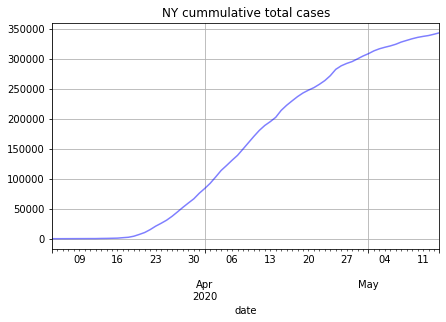

In [7]:
cases.plot(title=f"{state_name} cummulative total cases",
            c='b',
            alpha=.5,
            grid=True,
            figsize=(500/72, 300/72))


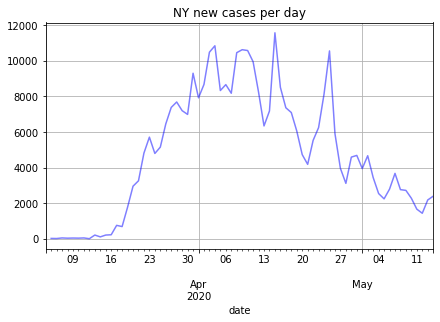

In [8]:
new_cases = cases.diff()   # compute the number of new cases per day:  basically,
                           # new_cases(i) = cases(i)-cases(i-1), and then new_cases(0) = NaN
    
new_cases.plot(title=f"{state_name} new cases per day",
               c='b',
               alpha=.5,
               grid=True,
               figsize=(500/72, 300/72))


In [9]:
# It's pretty noisy after computing difference.  Let's use a smoothing filter, and also remove the early days 
# when there are fewer than 25 new cases per day

def smooth_new_cases(new_cases, cutoff=25):
    # The function below does a "Gaussian rolling average" of the data. Basically it smooths out jumps in the data
    # the first argument -- '7' -- is the number of days over which to apply the average, i.e. filtered new_cases(i) 
    # is roughly an average over new_cases(i-3) to new_cases(i+3)
    
    new_cases_smoothed = new_cases.rolling(7, win_type='gaussian', min_periods=1,center=True).mean(std=2).round()
    
    # Ignore data before there are at least 25 new cases in a day
    idx_start = np.searchsorted(new_cases_smoothed, cutoff)     # Finds index where value in smoothed = cutoff
    new_cases_smoothed = new_cases_smoothed.iloc[idx_start:]
    
    return new_cases_smoothed



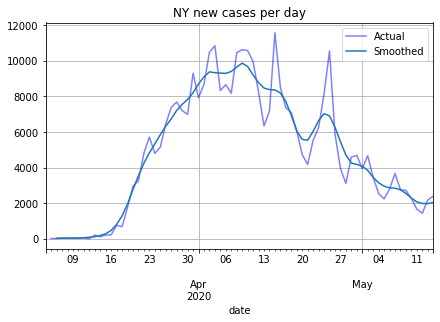

In [10]:
new_cases_smoothed = smooth_new_cases(new_cases)

new_cases.plot(title=f"{state_name} new cases per day",
               c='b',
               alpha=.5,
               label='Actual',
               legend=True,
               grid=True,
               figsize=(500/72, 300/72))

ax2 = new_cases_smoothed.plot(
                    label='Smoothed',
                    grid=True,
                    legend=True)

#ax2.get_figure().set_facecolor('w')
